# Mejorando la Precisión a través de convoluciones

En el anterior notebook hemos visto cómo implementar una red neuronal profunda con 3 capas, una capa de entrada, una capa oculta y la capa de salida. También hemos experimentado usando distinto número de unidades y capas ocultas para observar su efecto en la precisión del modelo entrenado.

Para una referencia conveniente, a continuación tenemos el código completo para tener un valor inicial de precisión:

In [1]:
# codigo visto previamente
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose

# dispositivo de entrenamiento
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Usando: {device}")

Usando: cpu


In [3]:
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Example normalization for single-channel (grayscale) images
])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

# bucle de entrenamiento

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # modo entrenamiento
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # mover si es necesario
        X = X.to(device)
        y = y.to(device)
        # forward
        # prediccion y costo
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# funcion de pruebas
def test_loop(dataloader, model, loss_fn):
    # modo evaluacion
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # evaluacion del modelo con torch.no_grad
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [4]:
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# bucle principal
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316300  [   64/60000]
loss: 2.295372  [ 6464/60000]
loss: 2.287366  [12864/60000]
loss: 2.269966  [19264/60000]
loss: 2.272079  [25664/60000]
loss: 2.260623  [32064/60000]
loss: 2.257854  [38464/60000]
loss: 2.241426  [44864/60000]
loss: 2.233166  [51264/60000]
loss: 2.218386  [57664/60000]
Test Error: 
 Accuracy: 31.8%, Avg loss: 2.210523 

Epoch 2
-------------------------------
loss: 2.222530  [   64/60000]
loss: 2.209573  [ 6464/60000]
loss: 2.174475  [12864/60000]
loss: 2.175629  [19264/60000]
loss: 2.159065  [25664/60000]
loss: 2.106586  [32064/60000]
loss: 2.146270  [38464/60000]
loss: 2.083053  [44864/60000]
loss: 2.083049  [51264/60000]
loss: 2.051258  [57664/60000]
Test Error: 
 Accuracy: 43.1%, Avg loss: 2.034617 

Epoch 3
-------------------------------
loss: 2.052550  [   64/60000]
loss: 2.037450  [ 6464/60000]
loss: 1.951336  [12864/60000]
loss: 1.984155  [19264/60000]
loss: 1.923343  [25664/60000]
loss: 1.837561  [32064/600

cómo podemos mejorar este rendimiento?

Una forma es usar algo llamado Convolución. Una Convolución es una operación matemática que puede ser aplicada a señales de distinta naturaleza, en este caso, la señal a aplicar será nuestra imagen y sus correspondientes mapas de características en las capas ocultas.

Pero antes de poder aplicar esta operación, debemos definir de mejor manera qué es y cómo se usa una convolución en imágenes.


## Convoluciones
En escencia, tendremos un arreglo llamado **parche** o **kernel** (usualmente de 3x3 o 5x5) y lo *deslizaremos* sobre la imagen en la que queremos operar. Se puede observar una visualización de la misma operación en la siguiente figura:

![tensor](conv1.gif)

en el caso anterior, un parche de 3x3 se desliza sobre una imagen original de tamaño 5x5 obteniendo como resultado una **nueva imagen** de tamaño 5x5, nótese que para que podamos tener una imagen del mismo tamaño original necesitamos agregar valores *extra* en los extremos de la imagen de entrada, esta técnica se denomina *padding*. 


## Kernels de convolución

En el contexto de las redes neuronales, intercambiaremos en nuestra arquitectura la estructura tradicional de las **neuronas** o unidades en las capas de la red por **filtros**. En la siguiente figura se puede visualizar el efecto de estos filtros.

![tensor](conv3.gif)

Por tanto, durante el entrenamiento, la tarea es encontrar los valores más adecuados de cada elemento de los filtros para minimizar la función de costo o pérdida.

La naturaleza y características de la operación de convolución son ideales para ser implementadas en tareas de visión artificial pues permiten a la red, a través de los filtros entrenados, *resaltar* las características más importantes para la predicción y mejora la eficiencia computacional pues nos enfocamos solamente en entrenar sobre ésas mismas características resaltadas.


## Fashion MNIST con una red convolucional

Una vez entendido el concepto e importancia de la operación de convolución podemos aplicarlo a nuestra tarea de clasificación de prendas de vestir.

Pyotch nos permite definir una capa especial llamada **Conv2D** que implementa todas las operaciones.

La implementación mejorada se vería así:


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.head = nn.Sequential(
            nn.Linear(in_features=800, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        features = self.backbone(x)
        # flatten tensor
        flat_features = features.view(features.size(0), -1)
        # apply the classifier
        logits = self.head(flat_features)
        return logits
    
model2 = ConvNet().to(device)
print(model2)

ConvNet(
  (backbone): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [6]:
learning_rate = 1e-4
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
# bucle principal
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn, optimizer)
    test_loop(test_dataloader, model2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304728  [   64/60000]
loss: 1.700937  [ 6464/60000]
loss: 0.802140  [12864/60000]
loss: 0.922193  [19264/60000]
loss: 0.825686  [25664/60000]
loss: 0.722001  [32064/60000]
loss: 0.686947  [38464/60000]
loss: 0.616610  [44864/60000]
loss: 0.633064  [51264/60000]
loss: 0.691709  [57664/60000]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.630145 

Epoch 2
-------------------------------
loss: 0.490884  [   64/60000]
loss: 0.642042  [ 6464/60000]
loss: 0.369789  [12864/60000]
loss: 0.652768  [19264/60000]
loss: 0.582558  [25664/60000]
loss: 0.583679  [32064/60000]
loss: 0.514017  [38464/60000]
loss: 0.557596  [44864/60000]
loss: 0.557708  [51264/60000]
loss: 0.561438  [57664/60000]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.542918 

Epoch 3
-------------------------------
loss: 0.379222  [   64/60000]
loss: 0.582581  [ 6464/60000]
loss: 0.309474  [12864/60000]
loss: 0.588835  [19264/60000]
loss: 0.517395  [25664/60000]
loss: 0.523272  [32064/600

Analice la diferencia en la precisión obtenida con nuestra nueva red convolucional.



## Ejercicios de exploración

Incremente el número de épocas en el entrenamiento y analice cuidadosamente el efecto en la precisión final tanto en el conjunto de entrenamiento como en el conjunto de validación.


## Visualizando las capas convolucionales

Visualizaremos los efectos de la convolución y los **mapas de características** de las capas ocultas de manera visual. 

De los 100 primeros ejemplos en el conjunto de pruebas, aquellos entre el índice 23 y 28 son zapatos. Analice la similaridad entre sus mapas de características.


In [7]:
feature_maps = []
# Define the hook function
def hook_fn(module, input, output):
    print("hooking...")
    feature_maps.append(output)

In [8]:
# Register hook to the layers you want to visualize
for layer in [model2.backbone[0], model2.backbone[3]]:  # Conv layers at index 0 and 3
    layer.register_forward_hook(hook_fn)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# Define the visualization function
def visualize_feature_maps(feature_maps, num_cols=8):
    for i, feature_map in enumerate(feature_maps):
        num_filters = feature_map.shape[1]
        num_rows = (num_filters + num_cols - 1) // num_cols  # Ensure enough rows
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
        
        for j in range(num_filters):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col]
            ax.imshow(feature_map[0, j].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
        
        for j in range(num_filters, num_rows * num_cols):  # Hide unused subplots
            row = j // num_cols
            col = j % num_cols
            axes[row, col].axis('off')

        fig.suptitle(f'Feature Map {i+1}')
        plt.show()

In [10]:
len(training_data[0])

2

In [11]:
image, label = training_data[10]
image = image.to(device)
label = torch.tensor(label).to(device)
# Clear previous feature maps
feature_maps.clear()
output = model2(image.unsqueeze(0))

hooking...
hooking...


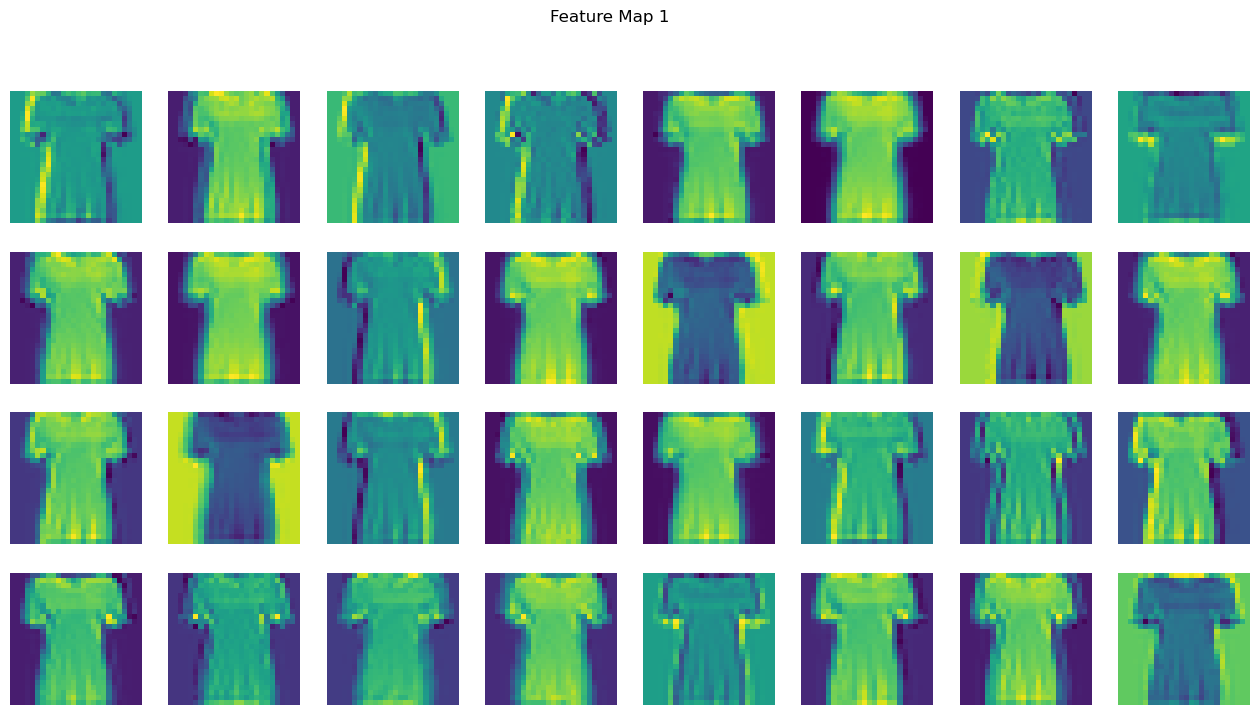

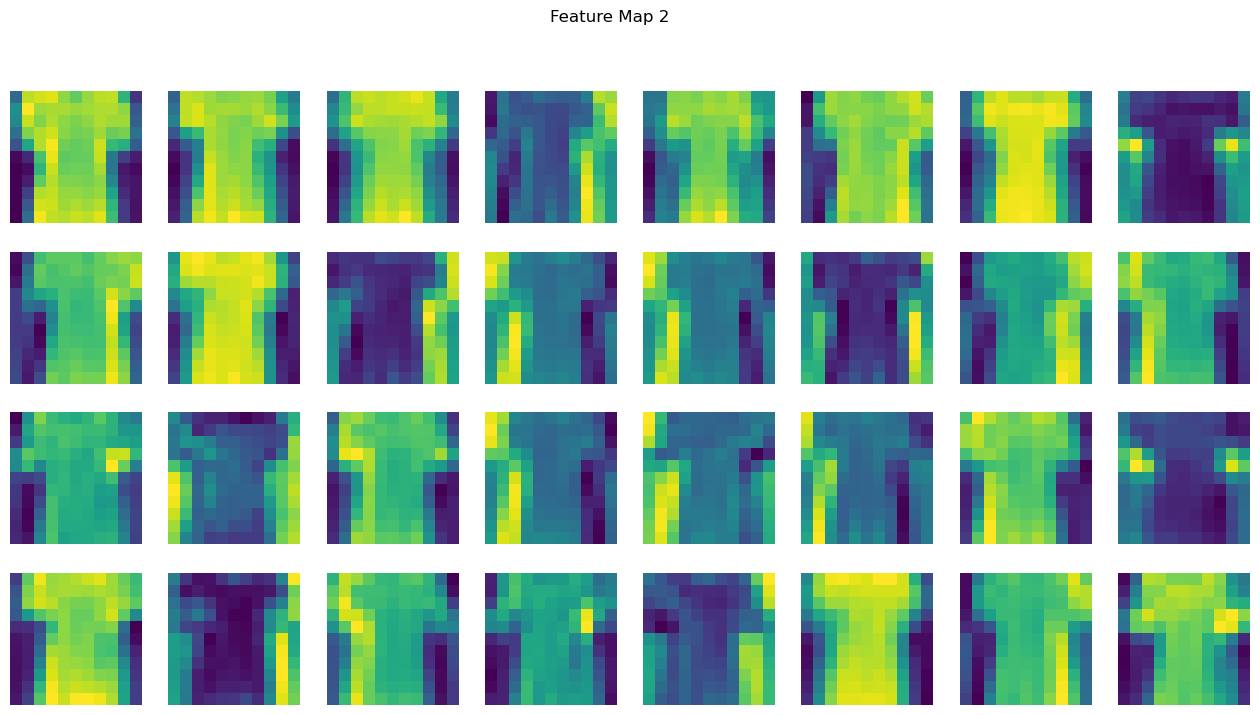

In [12]:
visualize_feature_maps([fm for fm in feature_maps])

## Ejercicios
1. Modifique la cantidad de filtros de convolución, cambie de 32 a 16 o 64, cuál es el impacto en la precisión y/o el tiempo de entrenamiento?
2. Elimine la última capa de convolución, cuál es el impacto?
3. Y qué pasa si se agregan nuevas capas de convolución?
